In [6]:
import base64
import os

from PIL import Image
from openai import OpenAI

img_path = "1.jpg"
with open(img_path, 'rb') as img_file:
    img_base = base64.b64encode(img_file.read()).decode('utf-8')

# 初始化OpenAI客户端
client = OpenAI(
    api_key=os.getenv("ALIYUN_BAILIAN_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

reasoning_content = ""  # 定义完整思考过程
answer_content = ""  # 定义完整回复
is_answering = False  # 判断是否结束思考过程并开始回复
enable_thinking = True
# 创建聊天完成请求
completion = client.chat.completions.create(
    model="qwen3-vl-plus",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{img_base}"
                    },
                },
                {"type": "text", "text": "这张图片中是猫还是狗？"},
            ],
        },
    ],
    stream=True,
    # enable_thinking 参数开启思考过程，thinking_budget 参数设置最大推理过程 Token 数
    extra_body={
        'enable_thinking': True,
        "thinking_budget": 81920},

    # 解除以下注释会在最后一个chunk返回Token使用量
    # stream_options={
    #     "include_usage": True
    # }
)

if enable_thinking:
    print("\n" + "=" * 20 + "思考过程" + "=" * 20 + "\n")

for chunk in completion:
    # 如果chunk.choices为空，则打印usage
    if not chunk.choices:
        print("\nUsage:")
        print(chunk.usage)
    else:
        delta = chunk.choices[0].delta
        # 打印思考过程
        if hasattr(delta, 'reasoning_content') and delta.reasoning_content != None:
            print(delta.reasoning_content, end='', flush=True)
            reasoning_content += delta.reasoning_content
        else:
            # 开始回复
            if delta.content != "" and is_answering is False:
                print("\n" + "=" * 20 + "完整回复" + "=" * 20 + "\n")
                is_answering = True
            # 打印回复过程
            print(delta.content, end='', flush=True)
            answer_content += delta.content

# print("=" * 20 + "完整思考过程" + "=" * 20 + "\n")
# print(reasoning_content)
# print("=" * 20 + "完整回复" + "=" * 20 + "\n")
# print(answer_content)



====================思考过程====================

用户现在需要判断图片里是猫还是狗。先看图片中的动物特征：体型、耳朵形状、面部结构。狗的话，耳朵可能更下垂或形状不同，而猫耳朵更尖。但这里动物坐着，耳朵是半立，毛发短，体型和面部更像狗。再看整体形态，狗的坐姿和面部特征（比如鼻子、嘴巴形状）。所以判断是狗。

====================完整回复====================

这张图片中的动物是狗。从它的外形特征（如耳朵形状、面部结构、身体姿态等）可以判断，这是一只狗而非猫。

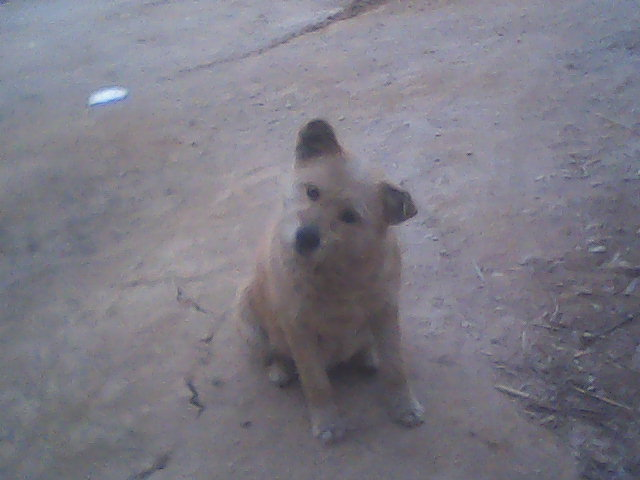

In [7]:
Image.open(img_path)